Este notebook lo usamos para sacar los datos de los recorridos que (por desgracia) se tienen que sacar a mano.

Cosas que pongo aquí porque si no se me olvidan:

* Los carriles se enumeran desde 0 (el derecho) hasta n (el más izquiero de todos). Eso quiere decir que los cambios son -1 a la derecha y +1 a la izquierda.
* Si el siguiente semáforo está muy lejos, nos da exactamente igual el estado en el que esté. Este hecho lo podemos usar para generar más datos.
* La precisión del GPS es un poco chusta, así que los resultados mejorarían dramáticamente en el caso de conseguir una mayor precisión en la toma de datos.

In [1]:
%matplotlib notebook

import os

import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pynsia.pointcloud import PointCloud
from sklearn.cluster import DBSCAN

import ipywidgets as widgets
from IPython.display import display

from pynsia import latlon, lidar

from utils import load_master_df, load_subject_df, DATASETS_INFO

figsize = (8, 4)

In [5]:
BASE_PATH = '/home/blazaid/Projects/data-phd/sync'
SUBJECT = 'jj'  # edgar, jj, miguel
DATASET = 'training'  # training, validation
calibration_data = {
    'pitch': 3.15,
    'roll': 0.5,
    'yaw': 0,
}

In [6]:
# Load the subject's data
df = load_subject_df(BASE_PATH, SUBJECT, DATASET, 'dataset')
# Select user info
dataset_info = DATASETS_INFO[SUBJECT][DATASET]
# Subject's path
SUBJECT_PATH = os.path.join(BASE_PATH, SUBJECT, DATASET)

## Subconjuntos de entrenamiento y test

De los conjuntos sincronizados originales extraeremos unos subconjuntos similares para trabajar con ellos, de tal manera que para cada sujeto los comienzos y los finales de las rutas sean aproximadamente los mismos.

Estos datos se han sacado visualizando los vídeos de los sujetos.

In [7]:
starting_frame = dataset_info['starting_frame'] or 0
ending_frame = dataset_info['ending_frame'] or (len(df) - 1)

print('Starting frame:\t{}'.format(starting_frame))
print('Ending frame:\t{}'.format(ending_frame))
print('New route len:\t{}'.format(ending_frame + 1 - starting_frame))
df = df[starting_frame:ending_frame + 1].reset_index(drop=True)

Starting frame:	150
Ending frame:	10580
New route len:	10431


## Cambios de carril

El cálculo de los cambios de carril (desgraciadamente) se hace a mano. Está definido en la variable DATASETS_INFO para cada conductor y dataset, y se ha obtenido mediante la visualización de los vídeos.

<IPython.core.display.Javascript object>


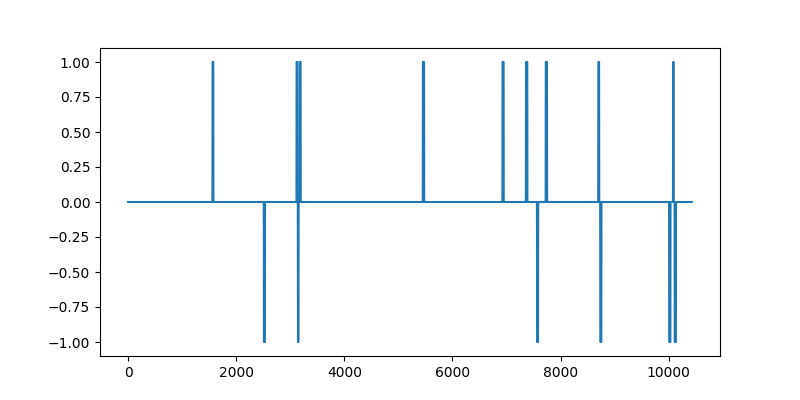

In [8]:
df['Lane change'] = 0
for ini_frame, end_frame, change in dataset_info['lane_changes']:
    df.loc[ini_frame:end_frame, 'Lane change'] = change
fig, ax = plt.subplots(1, 1, figsize=figsize)
df['Lane change'].plot(ax=ax);

## Velocidad máxima

Como en los cambios de carril, la velocidad máxima se ha extraído manualmente a partir de la información de los mapas de openstreetmap y de los vídeos de los recorridos.

<IPython.core.display.Javascript object>


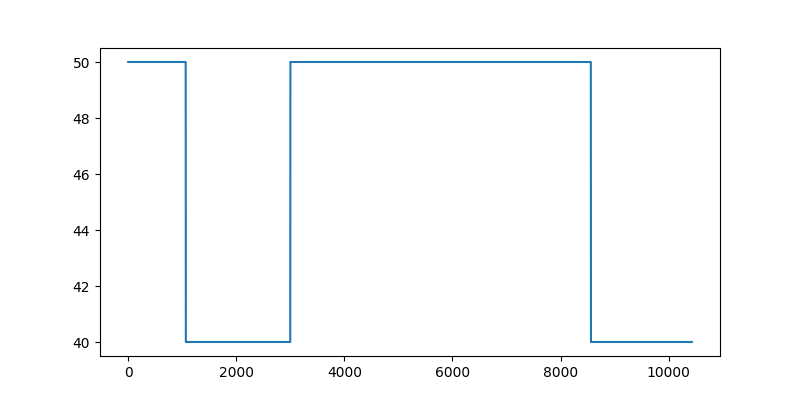

In [9]:
df['Max speed'] = 0
for frame, speed in dataset_info['max_speed']:
    df.loc[frame:, 'Max speed'] = speed
fig, ax = plt.subplots(1, 1, figsize=figsize)
df['Max speed'].plot(ax=ax);

## Distancias

Todas las distancias se calcularán más o menos de la misma manera (salvo la del vehículo delantero). Se tiene una tabla maestra con las posiciones de los puntos de interes contra los que calcular la distancia. A partir de ahí se generan tantas columnas como puntos de interes y tantas filas como filas tiene el recorrido. Después, de forma manual, se irá eligiendo qué punto de interes corresponde a qué intervalo y se generará la nueva tabla con dichos valores.

## Distancias a semáforos

Cada sujeto tiene un fichero con la información de cuál es el siguiente semáforo para cada distancia. Se generará por tanto una columna con las distancias al siguiente semáfolo y su estado.

In [ ]:
# Base TLS dataframe
master_tls_df = load_master_df(BASE_PATH, DATASET, 'tls')
master_tls_df = master_tls_df.set_index('tls')
# Subject tls's dataframe
tls_df = load_subject_df(BASE_PATH, SUBJECT, DATASET, 'tls')

In [ ]:
df['Next TLS distance'] = 0.0
df['Next TLS status'] = 0.0
for i, row in tls_df.iterrows():
    next_tls = row['next_tls']
    

    lat, lon = master_tls_df.loc[row['next_tls'],['lat', 'lon']]
    df.loc[row['frame']:,'Next TLS status'] = row['status']
    df.loc[row['frame']:,'Next TLS distance'] = df.loc[row['frame']:,['gps_positions_latitude', 'gps_positions_longitude']].apply(lambda r: latlon.distance(
        (r['gps_positions_latitude'], r['gps_positions_longitude']),
        (lat, lon)
    ), axis=1)

df[['Next TLS distance']].plot()

In [10]:
import time

lidar_calibration = lidar.calibration_matrix(**calibration_data)

def plt_image(ax, index, path):
    image = mpimg.imread(path)
    ax.clear()
    ax.imshow(image)
    ax.text(0, 0, 'Frame ' + str(index), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

def plt_lidar(ax, path, columns):
    pc = PointCloud.load(path)
    ax.clear()
    ax.set_xlim((-35, 35))
    ax.set_ylim((-35, 35))
    ax.set_aspect('equal', adjustable='box')
    points = np.concatenate([np.array([pc.points[:,0]]).T, pc.points[:,1:]], axis=1) 
    points = np.concatenate([points, np.ones((len(pc.points),1))], axis=1) 
    points = np.matmul(points, lidar_calibration)
    mask = (points[:,2] > 0.5) & \
           (points[:,2] < 2) & \
           (points[:,0] < 35) & \
           (points[:,0] > 0.35) & \
           (points[:,1] < 1.5) & \
           (points[:,1] > -1.5)
    masked_points = points[mask,:]
    other_points = points[np.logical_not(mask),:]

    # Look for clusters
    n_clusters = 0
    n_points = len(masked_points)
    dist = np.inf
    if len(masked_points) > 0:
        db = DBSCAN(eps=.5, min_samples=10).fit(masked_points)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        for cluster in range(n_clusters):
            obs = masked_points[labels == cluster]
            dist = min(dist, np.sqrt(np.mean(obs[:, 0])**2 + np.mean(obs[:, 1])**2))
    columns.append((n_clusters, n_points))
    
    ax.scatter(other_points[:,0], other_points[:,1], s=.01, color='b', alpha=0.1);
    ax.scatter(masked_points[:,0], masked_points[:,1], s=.1, color='r');
    ax.text(-30, 30, 'Clusters: ' + str(n_clusters), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    ax.text(-30, 20, 'Dist: ' + str(dist), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

<IPython.core.display.Javascript object>


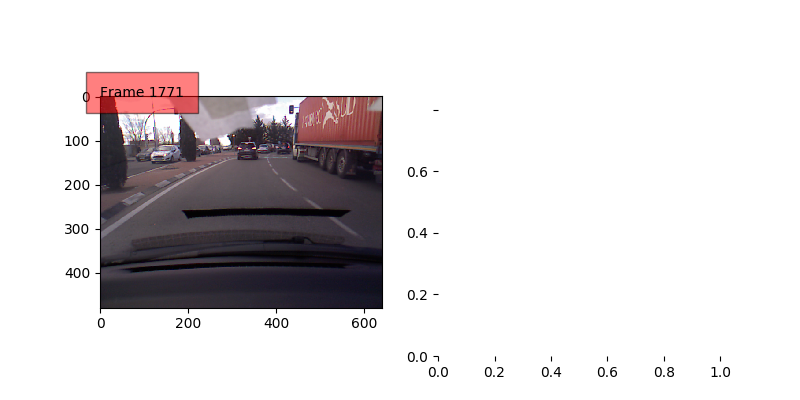

KeyboardInterrupt: 

In [13]:
from_index = 1284

fig, axs = plt.subplots(1, 2, figsize=figsize)
columns = []
for index, row in df.iterrows():
    if from_index is not None and from_index <= index:
        if not (pd.isnull(row['snapshots_path']) or pd.isnull(row['pointclouds_path'])):
            plt_image(axs[0], index, os.path.join(SUBJECT_PATH, row['snapshots_path']))
            #plt_lidar(axs[1], os.path.join(SUBJECT_PATH, row['pointclouds_path']), columns)

        fig.canvas.draw()
        #time.sleep(0.25)


lanes = [
    (0, 0, np.inf, 0),
    (874, np.inf, np.inf, 0),
    (1420, Y, np.inf, np.inf),
    (1695, 0, np.inf, np.inf),
]